# Introducing molecular dynamics

This hands-on workshop introduces the basic concepts of HOOMD-blue and will teach you how to run a molecular dynamics simulation. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**Google Colab users:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Utility code

Please ignore the content of these cells, they provide some helpful methods but are not part of the workshop.

Run them one at a time, then click the arrow by "Utility code" to hide them.



In [1]:
# This cell installs HOOMD-blue in Google Colab.
try:
    import google

    !pip install -q condacolab
    import condacolab

    condacolab.install_from_url(
        'https://github.com/glotzerlab/hoomd-workshop/releases/download/2023.1.0/hoomd-workshop-2023.1.0-Linux-x86_64.sh'
    )
except ModuleNotFoundError:
    pass

In [2]:
import gsd.hoomd
import hoomd
import IPython
import packaging.version
import PIL
import matplotlib
import matplotlib.pyplot as plt
import numpy
import math
import warnings
import fresnel
import itertools 
import io 
import freud 
import io
import warnings


device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    Lx = snapshot.configuration.box[0]
    Ly = snapshot.configuration.box[1]
    Lz = snapshot.configuration.box[2]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04

    if (hasattr(snapshot, 'log')
            and 'particles/md/pair/LJ/energies' in snapshot.log):
        energies = snapshot.log['particles/md/pair/LJ/energies']
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.colormaps['viridis'])
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1
    
    else:
        
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=-0.5,
                                              vmax=1,
                                              clip=True),
            cmap=matplotlib.colormaps['RdYlBu'])
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(snapshot.particles.typeid))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [Lx, Ly, Lz, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(Lx * 2, Ly, Lz * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=Lx * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=20)

def render_image(snapshot):
  a = render(snapshot)
  return IPython.display.Image(a._repr_png_())

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert("P")
       # "P", palette=PIL.Image.Palette.ADAPTIVE)
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f)
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if (size > 3000):
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))
 
warnings.filterwarnings('ignore', module='hoomd')
warnings.filterwarnings('ignore', module='numpy')

# Binary mixtures

Here, we introduce the concept of multiple particle types. First, we set up the system starting from an fcc crystal. 

In [ ]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=2)
snapshot = hoomd.Snapshot()
box, positions = freud.data.UnitCell.fcc().generate_system(num_replicas=5,
                                                           scale=1.8)
snapshot.particles.N = len(positions)
snapshot.particles.position[:] = positions
snapshot.particles.typeid[:] = [0] * len(positions)

We need to add a second type to the ``snapshpt.particle.types`` list. Call it "B". Now we also need to **change** the type of the particles in the $x>0$ half of the box:

In [ ]:
# add code
snapshot.particles.types = ['A','B']
snapshot.particles.typeid[snapshot.particles.position[:,0]>0] = 1

Now we can finish creating the snapshot and render it. Use the rendering to make sure the logic above is correct. 

In [ ]:
snapshot.configuration.box = [box.Lx, box.Ly, box.Lz, 0, 0, 0]
sim.create_state_from_snapshot(snapshot)
print("simulation box", snapshot.configuration.box)
print("overall density", len(positions)/(box.Lx*box.Ly*box.Lz))
image = render_image(snapshot)
image

## Pair interactions 

We also need to add all pair interactions (AA, AB, BB). For this example, use $\epsilon_{AB}=0.4$, and $\epsilon_{BB}=0.6$. Leave all $\sigma_{ij}$ at $1$, and set the cutoff for all interactions to $r_{cut}=2.5. 

In [ ]:
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
 
# Add code for AB and BB interactions:

## Run the simulation 

Just like before.

In [4]:
all_particles = hoomd.filter.All()
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=all_particles)
sim.operations += thermo
logger = hoomd.logging.Logger(categories=['scalar'])
logger.add(sim,quantities=['timestep'])
logger.add(thermo, quantities=['potential_energy','kinetic_energy','kinetic_temperature','pressure'])
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(1000),
                          logger=logger,
                          max_header_len=5,
                          max_precision=2)
sim.operations += table

## Thermostat and integrator

In [5]:
nvt = hoomd.md.methods.NVT(filter=hoomd.filter.All(), kT=0.4,tau=0.5)
integrator = hoomd.md.Integrator(dt=0.005,
                                 methods=[nvt],
                                 forces=[lj])
gsd_writer = hoomd.write.GSD(filename='binary_mixture_trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(int(1e3)),
                             mode='wb')
sim.operations.integrator = integrator
sim.operations.writers.append(gsd_writer)

## Run the simulation

In [6]:
sim.run(5e3)

 timestep  potential_energy kinetic_energy kinetic_temperature  pressure 
   1000      -2215.70069      313.18280          0.41841        0.69228  
   2000      -2377.46791      195.55480          0.26126        -1.02632 
   3000      -2198.10007      285.30179          0.38116        -0.64138 
   4000      -2214.11100      318.00297          0.42485        -0.13164 
   5000      -2244.84812      315.92740          0.42208        -0.47590 


Render trajectory of binary mixture:

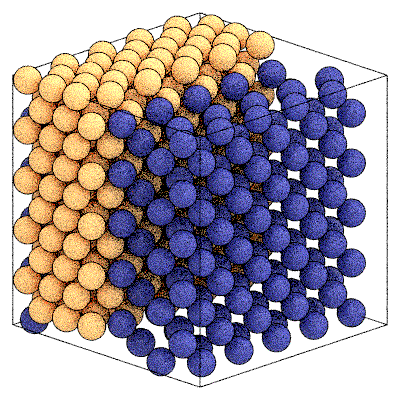

In [7]:
with gsd.hoomd.open('binary_mixture_trajectory.gsd', 'rb') as trajectory:
    image = render_movie(trajectory)
image